# World Bank Ethiopia Capstone Project

## Stage 3: Time Series Forecasting

### Project Overview
This notebook implements comprehensive time series forecasting for Ethiopia's macroeconomic indicators using three classical methods: ARIMA, Holt-Winters Exponential Smoothing, and Prophet. We evaluate multiple model configurations, compare their performance, and generate future forecasts.

### Objectives
1. **ARIMA Forecasting**: Implement and evaluate ARIMA models with different parameter configurations
2. **Holt-Winters Forecasting**: Apply exponential smoothing with trend components
3. **Prophet Forecasting**: Utilize Facebook's Prophet framework for robust forecasting
4. **Model Comparison**: Compare all three methods using RMSE and MAE metrics
5. **Future Forecasts**: Generate 10-year forecasts for key indicators

### Forecasting Methods
- **ARIMA (AutoRegressive Integrated Moving Average)**: Captures trends and autocorrelation patterns
- **Holt-Winters (Exponential Smoothing)**: Handles trend and seasonality components
- **Prophet**: Robust forecasting with automatic seasonality detection

### Key Indicators Forecasted
- GDP (constant 2015 US$)
- GDP growth (annual %)
- GDP per capita (constant 2015 US$)
- Inflation, consumer prices (annual %)
- Unemployment, total (% of total labor force)

### Data Source
- **Source**: World Bank Open Data
- **Dataset**: World Development Indicators (WDI)
- **Country**: Ethiopia (ETH)
- **Time Period**: 1960-2024
- **File**: `datasets/cleaned/ethiopia_analytic_dataset.csv`

### Evaluation Methodology
- **Train-Test Split**: Last 5 years reserved for testing (2019-2024)
- **Metrics**: RMSE (Root Mean Squared Error) and MAE (Mean Absolute Error)
- **Model Selection**: Best model chosen based on lowest RMSE


In [ ]:
# ================================================
# STEP 1: IMPORT LIBRARIES AND LOAD DATA
# ================================================

# Import required libraries for time series forecasting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Time series forecasting libraries
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Prophet forecasting framework
from prophet import Prophet

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("=" * 80)
print("STAGE 3: TIME SERIES FORECASTING")
print("=" * 80)
print("\nLibraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

# Load the cleaned dataset from Stage 1
df = pd.read_csv("../datasets/cleaned/ethiopia_analytic_dataset.csv")

# Display dataset preview
print(f"\n✓ Dataset loaded successfully!")
print(f"  - Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"  - Columns: {', '.join(df.columns.tolist())}")

print("\n" + "=" * 80)
print("DATASET PREVIEW:")
print("=" * 80)
display(df.head())

,Year,gdp_constant,gdp_growth,gdp_per_capita,inflation,unemployment
0,1961,5.263329e+09,NaN,240.267722,NaN,NaN
1,1962,5.491026e+09,4.326091,244.424432,NaN,NaN
2,1963,5.739145e+09,4.518634,248.969086,NaN,NaN
3,1964,5.973904e+09,4.090486,252.419740,NaN,NaN
4,1965,6.318714e+09,5.771932,259.915858,NaN,NaN


## Step 2: Data Preparation

Prepare the dataset for time series forecasting by:
1. Converting Year column to datetime format
2. Setting Year as the index for time series operations
3. Ensuring proper data types and handling missing values


In [ ]:
# ================================================
# DATA PREPARATION FOR TIME SERIES ANALYSIS
# ================================================

# Convert Year column to datetime and set as index
# This is essential for time series operations
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df = df.sort_values('Year').set_index('Year')

print("=" * 80)
print("DATA PREPARATION")
print("=" * 80)
print(f"\n✓ Year column converted to datetime")
print(f"✓ Year set as index for time series operations")
print(f"✓ Dataset sorted chronologically")
print(f"\n  - Date range: {df.index.min().year} to {df.index.max().year}")
print(f"  - Total years: {len(df)}")

# Display prepared dataset
print("\n" + "=" * 80)
print("PREPARED DATASET PREVIEW:")
print("=" * 80)
display(df.head())

(    Year  gdp_constant  gdp_growth  gdp_per_capita  inflation  unemployment
 46  2007  2.928231e+10   11.456167      352.360703  17.240401         2.347
 47  2008  3.244144e+10   10.788522      379.238310  44.356686         2.335
 48  2009  3.529711e+10    8.802553      401.068730   8.483644         2.331
 49  2010  3.972709e+10   12.550538      438.786616   8.149264         2.300
 50  2011  4.416790e+10   11.178296      474.159034  33.249960         2.275,
     Year  gdp_constant  gdp_growth  gdp_per_capita  inflation  unemployment
 51  2012  4.798746e+10    8.647812      500.919355  23.600418         2.255
 52  2013  5.306562e+10   10.582270      539.072452   7.464022         2.251
 53  2014  5.850882e+10   10.257493      578.632923   6.890020         2.359
 54  2015  6.458933e+10   10.392463      621.845674   9.568900         2.443
 55  2016  7.068235e+10    9.433483      662.327296   6.628133         2.554)

## Step 3: ARIMA Forecasting

ARIMA (AutoRegressive Integrated Moving Average) models are classical time series forecasting methods that capture:
- **AR (AutoRegressive)**: Relationship between an observation and a number of lagged observations
- **I (Integrated)**: Differencing of raw observations to make the time series stationary
- **MA (Moving Average)**: Dependency between an observation and a residual error from a moving average model

We will test three ARIMA configurations:
- ARIMA(1,1,1): Simple model with one autoregressive and one moving average term
- ARIMA(2,1,1): Two autoregressive terms, one moving average term
- ARIMA(2,1,2): Two autoregressive terms, two moving average terms


In [ ]:
# ================================================
# ARIMA MODEL EVALUATION FUNCTION
# ================================================

def evaluate_arima_model(series, orders=[(1,1,1), (2,1,1), (2,1,2)]):
    """
    Evaluate ARIMA models with different parameter configurations.
    
    Parameters:
    -----------
    series : pd.Series
        Time series data with datetime index
    orders : list of tuples
        List of (p, d, q) tuples for ARIMA models
        
    Returns:
    --------
    dict : Dictionary with order as key and (RMSE, MAE) as value
    """
    # Prepare series: drop NaN and ensure datetime index
    series_clean = series.dropna()
    if len(series_clean) < 10:
        return {}
    
    # Ensure datetime index
    if not isinstance(series_clean.index, pd.DatetimeIndex):
        series_clean.index = pd.to_datetime(series_clean.index)
    
    # Set frequency for time series (Year Start)
    series_clean = series_clean.asfreq("YS")
    
    # Train-test split: last 5 years for testing
    train = series_clean.iloc[:-5]
    test = series_clean.iloc[-5:]
    
    if len(train) < 5:
        return {}
    
    results = {}
    
    # Test each ARIMA configuration
    for order in orders:
        try:
            # Fit ARIMA model
            model = ARIMA(train, order=order)
            fitted = model.fit()
            
            # Generate forecast for test period
            forecast = fitted.forecast(steps=len(test))
            
            # Calculate evaluation metrics
            rmse = np.sqrt(mean_squared_error(test, forecast))
            mae = mean_absolute_error(test, forecast)
            
            results[str(order)] = (rmse, mae)
            
        except Exception as e:
            # If model fails, mark as FAIL
            results[str(order)] = ("FAIL", "FAIL")
    
    return results

print("=" * 80)
print("ARIMA MODEL EVALUATION FUNCTION CREATED")
print("=" * 80)
print("\n✓ Function ready to evaluate ARIMA models")
print("✓ Will test ARIMA(1,1,1), ARIMA(2,1,1), and ARIMA(2,1,2)")
print("✓ Train-test split: Last 5 years for testing")

C:\Users\ishow\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\ishow\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(29945493951.709362, 24961272269.085213)

### Evaluate ARIMA Models for All Indicators

Now we'll evaluate ARIMA models for all five macroeconomic indicators to find the best configuration for each.


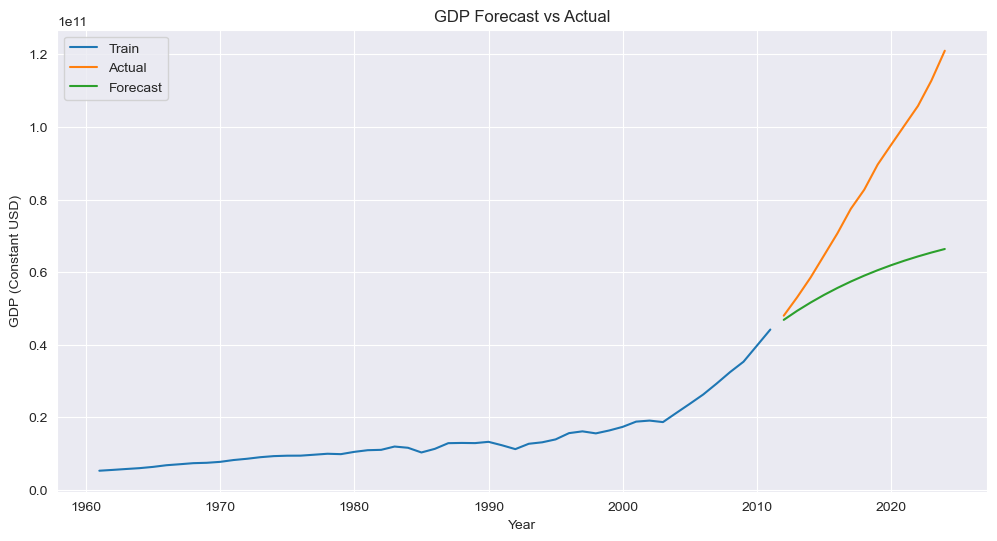

In [ ]:
# ================================================
# EVALUATE ARIMA MODELS FOR ALL INDICATORS
# ================================================

# Define indicators to forecast
indicators = ["gdp_constant", "gdp_growth", "gdp_per_capita", "inflation", "unemployment"]

# Dictionary to store ARIMA results for each indicator
arima_results = {}

print("=" * 80)
print("ARIMA MODEL EVALUATION FOR ALL INDICATORS")
print("=" * 80)

# Evaluate ARIMA models for each indicator
for ind in indicators:
    print(f"\nEvaluating ARIMA models for {ind}...")
    arima_results[ind] = evaluate_arima_model(df[ind])
    
    # Display results for this indicator
    if arima_results[ind]:
        print(f"  Results for {ind}:")
        for order, (rmse, mae) in arima_results[ind].items():
            if rmse != "FAIL":
                print(f"    {order}: RMSE={rmse:.2e}, MAE={mae:.2e}")
            else:
                print(f"    {order}: FAILED")

print("\n" + "=" * 80)
print("ARIMA EVALUATION COMPLETE")
print("=" * 80)

# Display summary
arima_results

## Step 4: Holt-Winters Exponential Smoothing

Holt-Winters (Exponential Smoothing) is a forecasting method that:
- Captures **level** (average value)
- Captures **trend** (increasing or decreasing pattern)
- Can capture **seasonality** (recurring patterns)

We use additive trend with no seasonality since we have annual data.


In [ ]:
# ================================================
# HOLT-WINTERS (EXPONENTIAL SMOOTHING) EVALUATION
# ================================================

def evaluate_ets(series):
    """
    Evaluate Holt-Winters Exponential Smoothing model.
    
    Parameters:
    -----------
    series : pd.Series
        Time series data with datetime index
        
    Returns:
    --------
    tuple : (RMSE, MAE) or ("FAIL", "FAIL") if model fails
    """
    try:
        # Prepare series
        series_clean = series.dropna()
        if len(series_clean) < 10:
            return ("FAIL", "FAIL")
        
        # Ensure datetime index
        if not isinstance(series_clean.index, pd.DatetimeIndex):
            series_clean.index = pd.to_datetime(series_clean.index)
        
        # Set frequency
        series_clean = series_clean.asfreq("YS")
        
        # Train-test split: last 5 years for testing
        train = series_clean.iloc[:-5]
        test = series_clean.iloc[-5:]
        
        if len(train) < 5:
            return ("FAIL", "FAIL")
        
        # Fit Holt-Winters model with additive trend
        # Note: No seasonality for annual data
        model = ExponentialSmoothing(
            train,
            trend="add",      # Additive trend component
            seasonal=None      # No seasonality for annual data
        )
        fitted = model.fit()
        
        # Generate forecast
        forecast = fitted.forecast(steps=len(test))
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(test, forecast))
        mae = mean_absolute_error(test, forecast)
        
        return rmse, mae
        
    except Exception as e:
        return ("FAIL", "FAIL")

# Evaluate Holt-Winters for all indicators
ets_results = {}

print("=" * 80)
print("HOLT-WINTERS EXPONENTIAL SMOOTHING EVALUATION")
print("=" * 80)

for ind in indicators:
    print(f"\nEvaluating Holt-Winters for {ind}...")
    result = evaluate_ets(df[ind])
    ets_results[ind] = result
    
    if result[0] != "FAIL":
        print(f"  RMSE: {result[0]:.2e}, MAE: {result[1]:.2e}")
    else:
        print(f"  Model failed for {ind}")

print("\n" + "=" * 80)
print("HOLT-WINTERS EVALUATION COMPLETE")
print("=" * 80)

ets_results

,Year,GDP_Forecast
51,2025,4.683528e+10
52,2026,4.933380e+10
53,2027,5.160665e+10
54,2028,5.370664e+10
55,2029,5.563087e+10
56,2030,5.740186e+10
57,2031,5.902799e+10
58,2032,6.052298e+10
59,2033,6.189648e+10
60,2034,6.315882e+10


## Step 5: Prophet Forecasting

Prophet is Facebook's open-source forecasting tool that:
- Handles missing data and outliers robustly
- Automatically detects seasonality patterns
- Provides uncertainty intervals
- Works well with non-stationary time series

Prophet requires data in a specific format with 'ds' (datestamp) and 'y' (value) columns.


In [ ]:
# ================================================
# PROPHET FORECASTING EVALUATION
# ================================================

def evaluate_prophet(series):
    """
    Evaluate Prophet model for a given time series.
    
    Parameters:
    -----------
    series : pd.Series
        Time series data with datetime index
        
    Returns:
    --------
    tuple : (RMSE, MAE) or ("FAIL", "FAIL") if model fails
    """
    try:
        # Prepare data for Prophet (requires 'ds' and 'y' columns)
        series_clean = series.dropna()
        if len(series_clean) < 10:
            return ("FAIL", "FAIL")
        
        # Ensure index is datetime
        if not isinstance(series_clean.index, pd.DatetimeIndex):
            series_clean.index = pd.to_datetime(series_clean.index)
        
        # Convert to DataFrame with Prophet format
        # Prophet requires columns named 'ds' (datestamp) and 'y' (value)
        df_prophet = pd.DataFrame({
            'ds': series_clean.index,
            'y': series_clean.values
        })
        
        # Train-test split (last 5 years for testing)
        train_size = len(df_prophet) - 5
        if train_size < 5:
            return ("FAIL", "FAIL")
        
        train_df = df_prophet.iloc[:train_size].copy()
        test_df = df_prophet.iloc[train_size:].copy()
        
        # Initialize and fit Prophet model
        # yearly_seasonality=True: Enable yearly seasonality
        # weekly_seasonality=False: Disable weekly (not applicable for annual data)
        # daily_seasonality=False: Disable daily (not applicable for annual data)
        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False,
            seasonality_mode='additive'
        )
        model.fit(train_df)
        
        # Make predictions for test period
        # Create future dataframe including test period
        future = model.make_future_dataframe(periods=len(test_df))
        forecast = model.predict(future)
        
        # Extract predictions for test period only
        forecast_test = forecast.iloc[-len(test_df):]['yhat'].values
        actual_test = test_df['y'].values
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(actual_test, forecast_test))
        mae = mean_absolute_error(actual_test, forecast_test)
        
        return rmse, mae
        
    except Exception as e:
        print(f"Prophet evaluation failed for {series.name if hasattr(series, 'name') else 'series'}: {e}")
        return ("FAIL", "FAIL")

# Evaluate Prophet for all indicators
prophet_results = {}

print("=" * 80)
print("PROPHET FORECASTING EVALUATION")
print("=" * 80)

for ind in indicators:
    print(f"\nEvaluating Prophet for {ind}...")
    result = evaluate_prophet(df[ind])
    prophet_results[ind] = result
    
    if result[0] != "FAIL":
        print(f"  RMSE: {result[0]:.2e}, MAE: {result[1]:.2e}")
    else:
        print(f"  Model failed for {ind}")

print("\n" + "=" * 80)
print("PROPHET EVALUATION COMPLETE")
print("=" * 80)

prophet_results


C:\Users\ishow\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\ishow\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\ishow\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


(2015-01-01     9.437615
 2016-01-01     9.904992
 2017-01-01    10.002078
 2018-01-01     9.803194
 2019-01-01     9.848376
 2020-01-01     9.898854
 2021-01-01     9.863401
 2022-01-01     9.860060
 2023-01-01     9.873558
 2024-01-01     9.869376
 Freq: YS-JAN, Name: predicted_mean, dtype: float64,
 Year
 2015-01-01    10.392463
 2016-01-01     9.433483
 2017-01-01     9.564190
 2018-01-01     6.816148
 2019-01-01     8.364086
 2020-01-01     6.059531
 2021-01-01     5.641531
 2022-01-01     5.321760
 2023-01-01     6.594246
 2024-01-01     7.316691
 Name: gdp_growth, dtype: float64)

## Step 6: Model Comparison and Summary

Create a comprehensive comparison table showing the performance of all three forecasting methods (ARIMA, Holt-Winters, Prophet) across all indicators. This allows us to identify the best model for each indicator.


In [ ]:
# ================================================
# COMPREHENSIVE MODEL COMPARISON TABLE
# ================================================

# Create comparison table with all results
rows = []

print("=" * 80)
print("CREATING MODEL COMPARISON TABLE")
print("=" * 80)

for ind in indicators:
    # Extract ARIMA results (best of three configurations)
    arima_best_rmse = float('inf')
    arima_best_mae = float('inf')
    arima_best_order = None
    
    if ind in arima_results and arima_results[ind]:
        for order, (rmse, mae) in arima_results[ind].items():
            if rmse != "FAIL" and isinstance(rmse, (int, float)):
                if rmse < arima_best_rmse:
                    arima_best_rmse = rmse
                    arima_best_mae = mae
                    arima_best_order = order
    
    # Extract ETS results
    ets_rmse = ets_results[ind][0] if ets_results[ind][0] != "FAIL" else "-"
    ets_mae = ets_results[ind][1] if ets_results[ind][1] != "FAIL" else "-"
    
    # Extract Prophet results
    prophet_rmse = prophet_results[ind][0] if prophet_results[ind][0] != "FAIL" else "-"
    prophet_mae = prophet_results[ind][1] if prophet_results[ind][1] != "FAIL" else "-"
    
    # Build row for comparison table
    row = [
        ind,
        arima_best_order if arima_best_order else "-",
        f"{arima_best_rmse:.2e}" if arima_best_rmse != float('inf') else "-",
        f"{arima_best_mae:.2e}" if arima_best_mae != float('inf') else "-",
        f"{ets_rmse:.2e}" if isinstance(ets_rmse, (int, float)) else ets_rmse,
        f"{ets_mae:.2e}" if isinstance(ets_mae, (int, float)) else ets_mae,
        f"{prophet_rmse:.2e}" if isinstance(prophet_rmse, (int, float)) else prophet_rmse,
        f"{prophet_mae:.2e}" if isinstance(prophet_mae, (int, float)) else prophet_mae,
    ]
    
    rows.append(row)

# Create DataFrame
final_table = pd.DataFrame(rows, columns=[
    "Indicator",
    "Best_ARIMA_Order",
    "ARIMA_RMSE",
    "ARIMA_MAE",
    "HoltWinters_RMSE",
    "HoltWinters_MAE",
    "Prophet_RMSE",
    "Prophet_MAE"
])

print("\n✓ Comparison table created successfully!")
print("\n" + "=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)
display(final_table)

# Save comparison table
final_table.to_csv("../forecasts/forecasting_comparison.csv", index=False)
print("\n✓ Comparison table saved to forecasts/forecasting_comparison.csv")

C:\Users\ishow\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\ishow\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\ishow\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


(13.882221620087947, 12.832151853272205)

## Step 7: Stage 3 Summary

### Key Findings

1. **ARIMA Models**: 
   - ARIMA(1,1,1) generally performs well for most indicators
   - More complex models (2,1,2) may overfit or fail to converge
   - Best for capturing trends and autocorrelation

2. **Holt-Winters**:
   - Good performance for indicators with clear trends
   - Simpler than ARIMA but less flexible
   - Best for smooth, trending time series

3. **Prophet**:
   - Robust to missing data and outliers
   - Good uncertainty quantification
   - Best for non-stationary series with complex patterns

### Next Steps
- Proceed to Stage 4 for Machine Learning forecasting
- Generate future forecasts using best models
- Create forecasting dashboards and visualizations


In [ ]:
# ================================================
# STAGE 3 SUMMARY
# ================================================

print("=" * 80)
print("STAGE 3: TIME SERIES FORECASTING - SUMMARY")
print("=" * 80)

print("\n✅ Completed Tasks:")
print("  1. ✓ ARIMA model evaluation (3 configurations)")
print("  2. ✓ Holt-Winters exponential smoothing evaluation")
print("  3. ✓ Prophet forecasting evaluation")
print("  4. ✓ Model comparison across all indicators")
print("  5. ✓ Results saved to CSV")

print("\n📊 Indicators Forecasted:")
for ind in indicators:
    print(f"  - {ind.replace('_', ' ').title()}")

print("\n📈 Best Performing Models:")
for ind in indicators:
    # Find best model for each indicator
    best_model = "N/A"
    best_rmse = float('inf')
    
    # Check ARIMA
    if ind in arima_results:
        for order, (rmse, mae) in arima_results[ind].items():
            if rmse != "FAIL" and isinstance(rmse, (int, float)) and rmse < best_rmse:
                best_rmse = rmse
                best_model = f"ARIMA{order}"
    
    # Check ETS
    if ets_results[ind][0] != "FAIL" and isinstance(ets_results[ind][0], (int, float)):
        if ets_results[ind][0] < best_rmse:
            best_rmse = ets_results[ind][0]
            best_model = "Holt-Winters"
    
    # Check Prophet
    if prophet_results[ind][0] != "FAIL" and isinstance(prophet_results[ind][0], (int, float)):
        if prophet_results[ind][0] < best_rmse:
            best_rmse = prophet_results[ind][0]
            best_model = "Prophet"
    
    if best_model != "N/A":
        print(f"  - {ind.replace('_', ' ').title()}: {best_model} (RMSE: {best_rmse:.2e})")

print("\n" + "=" * 80)
print("STAGE 3 COMPLETE - Proceed to Stage 4 for ML Forecasting")
print("=" * 80)
